# Workshop 1: ตรวจจับใบหน้า (Face Detection)

In [1]:
!pip install mtcnn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.2 MB/s eta 0:00:00


In [2]:
!pip install Pillow

In [3]:
import numpy as np
from mtcnn.mtcnn import MTCNN
from PIL import Image, ImageDraw

## เตรียมภาพและเปิดดู

In [4]:
rootdir = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/face/"
filename = rootdir + "candidates_manifesto.png"

im = Image.open(filename).convert("RGB")
print("img size:", im.size)

scale = 0.4
im = im.resize((round(im.size[0] * scale), round(im.size[1] * scale)))
print("img size:", im.size)

img size: (976, 549)
img size: (390, 220)


## ตัดเฉพาะใบหน้า

In [5]:
detector = MTCNN()

im_arr = np.array(im)
faces = detector.detect_faces(im_arr)
print(f'Found {len(faces)} face(s)')
faces

1/1 [==============================] - 0s 347ms/step
Found 5 face(s)


[{'box': [6, 78, 66, 84],
  'confidence': 0.9999969601631165,
  'keypoints': {'left_eye': (19, 115),
   'right_eye': (45, 109),
   'nose': (30, 127),
   'mouth_left': (25, 143),
   'mouth_right': (50, 138)}},
 {'box': [234, 37, 57, 71],
  'confidence': 0.9999903440475464,
  'keypoints': {'left_eye': (248, 68),
   'right_eye': (272, 64),
   'nose': (259, 80),
   'mouth_left': (252, 91),
   'mouth_right': (275, 88)}},
 {'box': [164, 64, 51, 75],
  'confidence': 0.9999632239341736,
  'keypoints': {'left_eye': (176, 94),
   'right_eye': (200, 93),
   'nose': (189, 109),
   'mouth_left': (178, 119),
   'mouth_right': (201, 118)}},
 {'box': [82, 35, 53, 69],
  'confidence': 0.9999179840087891,
  'keypoints': {'left_eye': (93, 64),
   'right_eye': (117, 61),
   'nose': (102, 74),
   'mouth_left': (94, 88),
   'mouth_right': (118, 86)}},
 {'box': [317, 81, 47, 63],
  'confidence': 0.9998767375946045,
  'keypoints': {'left_eye': (332, 106),
   'right_eye': (353, 104),
   'nose': (345, 119),
   

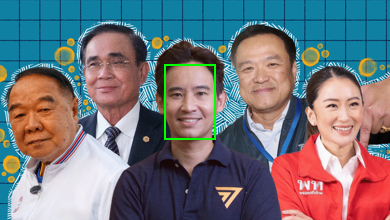

In [6]:
x1, y1, width, height = faces[2]["box"]
x2, y2 = x1 + width, y1 + height

draw = ImageDraw.Draw(im)
draw.rectangle([(x1, y1), (x2, y2)], outline=(0, 255, 0), width=2)
im

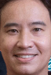

In [7]:
face = im_arr[y1:y2, x1:x2]
im_face = Image.fromarray(face)
im_face

# Workshop 2: สกัดหาข้อมูลเด่นของใบหน้า

In [8]:
from tqdm import tqdm
from os import listdir
from tensorflow.keras.models import load_model

## เตรียมภาพและเปิดดูภาพ

In [9]:
rootdir = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/face/"
filename = rootdir + "candidates_manifesto.png"

im = Image.open(filename).convert("RGB")
print("img size:", im.size)

scale = 0.4
im = im.resize((round(im.size[0] * scale), round(im.size[1] * scale)))
print("img size:", im.size)

img size: (976, 549)
img size: (390, 220)


In [10]:
detector = MTCNN()

def extract_face(filename, required_size=(160, 160), detector=detector):
  image = Image.open(filename).convert("RGB")
  im_arr = np.array(image)

  faces = detector.detect_faces(im_arr)
  x1, y1, width, height = faces[0]['box']
  x2, y2 = x1 + width, y1 + height
  face = im_arr[y1:y2, x1:x2]

  image = Image.fromarray(face)
  image = image.resize(required_size)
  face_array = np.asarray(image)
  return face_array

1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 182ms/step
(160, 160, 3)


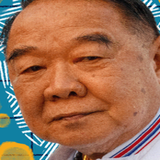

In [11]:
face_pixels = extract_face(filename)
print(face_pixels.shape)
Image.fromarray(face_pixels)

# Workshop 3: หาค่าความคล้ายระหว่างใบหน้า

In [12]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10370 sha256=911c030ec115c11c8543c703ca0d6ba8a366fac84d5f00e3fa0a354107013ca7
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [13]:
from keras_facenet import FaceNet

In [14]:
facenet_model = FaceNet()

In [15]:
def get_embedding(facenet_model, face):
  face_pixels = face.astype('float32')
  detections = facenet_model.extract(face_pixels, threshold=0.95)
  # mean = face_pixels.mean()
  # std = face_pixels.std()
  # face_pixels = (face_pixels - mean) / std
  sample = np.expand_dims(face_pixels, axis=0)
  emb_face = facenet_model.embeddings(sample)
  return emb_face[0]

def euclideanDistance(source_represent, test_represent):
  euclidean_dist = source_represent - test_represent
  euclidean_dist = np.sum(np.multiply(euclidean_dist, euclidean_dist))
  euclidean_dist = np.sqrt(euclidean_dist)
  return euclidean_dist

def dist_face(model, file1, file2):
  im_arr1 = extract_face(file1)
  emd1 = get_embedding(model, im_arr1)

  im_arr2 = extract_face(file2)
  emd2 = get_embedding(model, im_arr2)
  return euclideanDistance(emd1, emd2)

In [16]:
kob1 = rootdir + 'ทิมพิธา1.jpg'
kob2 = rootdir + 'ทิมพิธา2.jpg'

print(dist_face(facenet_model, kob1, kob2))

1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 257ms/step
0.56384176


In [17]:
ben1 = rootdir + 'หมอ.jpg'

print(dist_face(facenet_model, kob2, ben1))

1/1 [==============================] - 0s 229ms/step
1.2934527


In [18]:
def cosineSimilarity(source_represent, test_represent):
  a = np.matmul(np.transpose(source_represent), test_represent)
  b = np.sum(np.multiply(source_represent, source_represent))
  c = np.sum(np.multiply(test_represent, test_represent))
  return (a / (np.sqrt(b) * np.sqrt(c)))

def cosine_face(model, file1, file2):
  im_arr1 = extract_face(file1)
  emd1 = get_embedding(model, im_arr1)

  im_arr2 = extract_face(file2)
  emd2 = get_embedding(model, im_arr2)
  return cosineSimilarity(emd1, emd2)

print(cosine_face(facenet_model, kob1, kob2))
print(cosine_face(facenet_model, kob1, ben1))

1/1 [==============================] - 0s 258ms/step
0.8410412
1/1 [==============================] - 0s 172ms/step
0.21805888


In [19]:
cosine_similar = cosine_face(facenet_model, kob1, kob2)
print("cosine similarity: ", cosine_similar)
threshold = 0.5
if cosine_similar >= threshold:
  print("verified... same person")
else:
  print("unverified! Different person")

1/1 [==============================] - 0s 127ms/step
cosine similarity:  0.8410412
verified... same person


# Workshop 4: Face Recognition

In [20]:
rootdir = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/face/datasets/"

## เตรียมข้อมูล

In [21]:
def load_face(dir):
  faces = list()
  for filename in tqdm(listdir(dir)):
    path = dir + filename
    face = extract_face(path)
    faces.append(face)
  return faces

def load_dataset(dir):
  X, y = list(), list()
  for subdir in listdir(dir):
    path = dir + subdir + '/'
    faces = load_face(path)
    labels = [subdir for i in range(len(faces))]
    print("load %d sample(s) for class: %s" % (len(faces), subdir))
    X.extend(faces)
    y.extend(labels)
  return np.array(X), np.array(y)

trainX, trainy = load_dataset(rootdir + 'train/')
print('X shape, y shape:', trainX.shape, trainy.shape)
testX, testy = load_dataset(rootdir + 'val/')
print('X shape, y shape:', testX.shape, testy.shape)
np.savez_compressed('5_cele_faces_dataset.npz', trainX, trainy, testX, testy)

  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 1/14 [00:00<00:11,  1.15it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 2/14 [00:02<00:12,  1.03s/it]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 3/14 [00:03<00:11,  1.08s/it]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 4/14 [00:04<00:10,  1.07s/it]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 5/14 [00:05<00:09,  1.00s/it]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 6/14 [00:06<00:08,  1.01s/it]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 7/14 [00:07<00:08,  1.17s/it]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 8/14 [00:08<00:07,  1.19s/it]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 9/14 [00:10<00:06,  1.21s/it]

1/1 [==============================] - 0s 53ms/step


 71%|███████▏  | 10/14 [00:11<00:05,  1.35s/it]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 11/14 [00:13<00:04,  1.54s/it]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 12/14 [00:14<00:02,  1.38s/it]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 13/14 [00:15<00:01,  1.28s/it]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 14/14 [00:16<00:00,  1.20s/it]


load 14 sample(s) for class: ben_afflek


  0%|          | 0/19 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 1/19 [00:00<00:16,  1.07it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 2/19 [00:02<00:19,  1.15s/it]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 3/19 [00:03<00:17,  1.09s/it]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 4/19 [00:04<00:15,  1.03s/it]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 5/19 [00:05<00:14,  1.04s/it]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 6/19 [00:06<00:13,  1.06s/it]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 7/19 [00:07<00:14,  1.23s/it]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 8/19 [00:09<00:14,  1.33s/it]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 9/19 [00:10<00:13,  1.35s/it]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 10/19 [00:11<00:11,  1.26s/it]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 11/19 [00:13<00:09,  1.24s/it]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 12/19 [00:14<00:08,  1.20s/it]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 13/19 [00:15<00:06,  1.12s/it]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 14/19 [00:16<00:05,  1.10s/it]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 15/19 [00:17<00:04,  1.08s/it]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 16/19 [00:18<00:03,  1.04s/it]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 17/19 [00:19<00:02,  1.03s/it]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 18/19 [00:20<00:01,  1.05s/it]

1/1 [==============================] - 0s 47ms/step


100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


load 19 sample(s) for class: madonna


  0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 1/21 [00:01<00:29,  1.49s/it]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 2/21 [00:02<00:25,  1.35s/it]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 3/21 [00:03<00:22,  1.26s/it]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 4/21 [00:04<00:20,  1.18s/it]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 5/21 [00:06<00:18,  1.18s/it]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 6/21 [00:07<00:17,  1.15s/it]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 7/21 [00:08<00:15,  1.14s/it]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 8/21 [00:09<00:14,  1.09s/it]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 9/21 [00:10<00:12,  1.08s/it]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 10/21 [00:11<00:11,  1.05s/it]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 11/21 [00:12<00:11,  1.11s/it]

1/1 [==============================] - 0s 69ms/step


 57%|█████▋    | 12/21 [00:14<00:11,  1.25s/it]

1/1 [==============================] - 0s 71ms/step


 62%|██████▏   | 13/21 [00:15<00:11,  1.40s/it]

1/1 [==============================] - 0s 76ms/step


 67%|██████▋   | 14/21 [00:17<00:10,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 71%|███████▏  | 15/21 [00:19<00:10,  1.68s/it]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 16/21 [00:20<00:07,  1.49s/it]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 17/21 [00:21<00:05,  1.29s/it]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 18/21 [00:23<00:04,  1.34s/it]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 19/21 [00:24<00:02,  1.31s/it]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 20/21 [00:25<00:01,  1.23s/it]

1/1 [==============================] - 0s 45ms/step


100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


load 21 sample(s) for class: jerry_seinfeld


  0%|          | 0/17 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 1/17 [00:00<00:15,  1.00it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 2/17 [00:01<00:14,  1.03it/s]

1/1 [==============================] - 0s 65ms/step


 18%|█▊        | 3/17 [00:03<00:17,  1.28s/it]

1/1 [==============================] - 0s 60ms/step


 24%|██▎       | 4/17 [00:05<00:17,  1.38s/it]

1/1 [==============================] - 0s 67ms/step


 29%|██▉       | 5/17 [00:06<00:16,  1.37s/it]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 6/17 [00:07<00:13,  1.26s/it]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 7/17 [00:08<00:12,  1.22s/it]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 8/17 [00:09<00:10,  1.18s/it]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 9/17 [00:10<00:09,  1.16s/it]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 10/17 [00:12<00:08,  1.16s/it]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 11/17 [00:13<00:06,  1.13s/it]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 12/17 [00:14<00:05,  1.08s/it]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 13/17 [00:15<00:04,  1.04s/it]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 14/17 [00:16<00:03,  1.07s/it]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 15/17 [00:17<00:02,  1.23s/it]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 16/17 [00:19<00:01,  1.27s/it]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


load 17 sample(s) for class: elton_john


  0%|          | 0/22 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 1/22 [00:01<00:23,  1.12s/it]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 2/22 [00:02<00:22,  1.10s/it]

1/1 [==============================] - 0s 36ms/step


 14%|█▎        | 3/22 [00:03<00:21,  1.14s/it]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 4/22 [00:04<00:21,  1.19s/it]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 5/22 [00:05<00:18,  1.11s/it]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 6/22 [00:06<00:18,  1.13s/it]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 7/22 [00:07<00:16,  1.11s/it]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 8/22 [00:08<00:15,  1.11s/it]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 9/22 [00:10<00:14,  1.08s/it]

1/1 [==============================] - 0s 55ms/step


 45%|████▌     | 10/22 [00:11<00:14,  1.19s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 11/22 [00:12<00:13,  1.26s/it]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 12/22 [00:14<00:12,  1.29s/it]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 13/22 [00:15<00:11,  1.23s/it]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 14/22 [00:16<00:09,  1.23s/it]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 15/22 [00:17<00:08,  1.23s/it]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 16/22 [00:18<00:07,  1.17s/it]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 17/22 [00:19<00:05,  1.16s/it]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 18/22 [00:20<00:04,  1.11s/it]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 19/22 [00:21<00:03,  1.07s/it]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 20/22 [00:22<00:02,  1.06s/it]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 21/22 [00:23<00:01,  1.04s/it]

1/1 [==============================] - 0s 43ms/step


100%|██████████| 22/22 [00:25<00:00,  1.15s/it]

load 22 sample(s) for class: mindy_kaling
X shape, y shape: (93, 160, 160, 3) (93,)



  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


 20%|██        | 1/5 [00:01<00:05,  1.32s/it]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 2/5 [00:02<00:03,  1.24s/it]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 3/5 [00:03<00:02,  1.16s/it]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 4/5 [00:04<00:01,  1.15s/it]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


load 5 sample(s) for class: ben_afflek


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 1/5 [00:01<00:04,  1.13s/it]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 2/5 [00:02<00:03,  1.06s/it]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 3/5 [00:03<00:02,  1.06s/it]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 4/5 [00:04<00:01,  1.08s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


load 5 sample(s) for class: jerry_seinfeld


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 20%|██        | 1/5 [00:01<00:04,  1.17s/it]

1/1 [==============================] - 0s 64ms/step


 40%|████      | 2/5 [00:02<00:03,  1.31s/it]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 3/5 [00:03<00:02,  1.30s/it]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 4/5 [00:05<00:01,  1.30s/it]

1/1 [==============================] - 0s 38ms/step


100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


load 5 sample(s) for class: mindy_kaling


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 1/5 [00:01<00:04,  1.14s/it]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 2/5 [00:02<00:03,  1.14s/it]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 3/5 [00:03<00:02,  1.06s/it]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 4/5 [00:04<00:01,  1.05s/it]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


load 5 sample(s) for class: elton_john


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 1/5 [00:01<00:04,  1.13s/it]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 2/5 [00:02<00:03,  1.08s/it]

1/1 [==============================] - 0s 68ms/step


 60%|██████    | 3/5 [00:04<00:03,  1.53s/it]

1/1 [==============================] - 0s 79ms/step


 80%|████████  | 4/5 [00:07<00:02,  2.12s/it]

1/1 [==============================] - 0s 83ms/step


100%|██████████| 5/5 [00:09<00:00,  1.93s/it]

load 5 sample(s) for class: madonna
X shape, y shape: (25, 160, 160, 3) (25,)


In [22]:
data = np.load('5_cele_faces_dataset.npz')

trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


## หาค่า embedding

In [23]:
facenet_model = FaceNet()

In [24]:
emdTrainX = list()
for face in tqdm(trainX):
  emd = get_embedding(facenet_model, face)
  emdTrainX.append(emd)

emdTrainX = np.asanyarray(emdTrainX)
print('Train Embedding shape', emdTrainX.shape)

emdTestX = list()
for face in tqdm(testX):
  emd = get_embedding(facenet_model, face)
  emdTestX.append(emd)

emdTestX = np.asanyarray(emdTestX)
print('\nTest Embedding shape', emdTestX.shape)

np.savez_compressed('5_cele_faces_dataset.npz', emdTrainX, trainy, emdTestX, testy)

  0%|          | 0/93 [00:00<?, ?it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 1/93 [00:04<07:01,  4.58s/it]

1/1 [==============================] - 0s 110ms/step


  2%|▏         | 2/93 [00:06<04:10,  2.75s/it]

1/1 [==============================] - 0s 116ms/step


  3%|▎         | 3/93 [00:07<03:05,  2.06s/it]

1/1 [==============================] - 0s 110ms/step


  4%|▍         | 4/93 [00:08<02:30,  1.69s/it]

1/1 [==============================] - 0s 105ms/step


  5%|▌         | 5/93 [00:09<02:10,  1.48s/it]

1/1 [==============================] - 0s 104ms/step


  6%|▋         | 6/93 [00:10<01:55,  1.33s/it]

1/1 [==============================] - 0s 93ms/step


  8%|▊         | 7/93 [00:11<01:42,  1.20s/it]

1/1 [==============================] - 0s 106ms/step


  9%|▊         | 8/93 [00:12<01:34,  1.12s/it]

1/1 [==============================] - 0s 116ms/step


 10%|▉         | 9/93 [00:13<01:34,  1.12s/it]

1/1 [==============================] - 0s 93ms/step


 11%|█         | 10/93 [00:14<01:33,  1.12s/it]

1/1 [==============================] - 0s 398ms/step


 12%|█▏        | 11/93 [00:16<01:42,  1.26s/it]

1/1 [==============================] - 0s 267ms/step


 13%|█▎        | 12/93 [00:18<02:04,  1.54s/it]

1/1 [==============================] - 0s 278ms/step


 14%|█▍        | 13/93 [00:20<02:24,  1.81s/it]

1/1 [==============================] - 0s 226ms/step


 15%|█▌        | 14/93 [00:22<02:26,  1.85s/it]

1/1 [==============================] - 0s 227ms/step


 16%|█▌        | 15/93 [00:24<02:14,  1.72s/it]

1/1 [==============================] - 0s 110ms/step


 17%|█▋        | 16/93 [00:26<02:15,  1.76s/it]

1/1 [==============================] - 0s 308ms/step


 18%|█▊        | 17/93 [00:27<02:03,  1.62s/it]

1/1 [==============================] - 0s 100ms/step


 19%|█▉        | 18/93 [00:28<01:59,  1.60s/it]

1/1 [==============================] - 0s 186ms/step


 20%|██        | 19/93 [00:30<01:53,  1.54s/it]

1/1 [==============================] - 0s 188ms/step


 22%|██▏       | 20/93 [00:32<02:10,  1.79s/it]

1/1 [==============================] - 0s 179ms/step


 23%|██▎       | 21/93 [00:35<02:21,  1.97s/it]

1/1 [==============================] - 0s 90ms/step


 24%|██▎       | 22/93 [00:36<02:00,  1.70s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██▍       | 23/93 [00:37<01:44,  1.49s/it]

1/1 [==============================] - 0s 99ms/step


 26%|██▌       | 24/93 [00:38<01:37,  1.41s/it]

1/1 [==============================] - 0s 103ms/step


 27%|██▋       | 25/93 [00:39<01:24,  1.25s/it]

1/1 [==============================] - 0s 102ms/step


 28%|██▊       | 26/93 [00:40<01:19,  1.19s/it]

1/1 [==============================] - 0s 98ms/step


 29%|██▉       | 27/93 [00:41<01:15,  1.15s/it]

1/1 [==============================] - 0s 115ms/step


 30%|███       | 28/93 [00:42<01:11,  1.10s/it]

1/1 [==============================] - 0s 108ms/step


 31%|███       | 29/93 [00:43<01:11,  1.11s/it]

1/1 [==============================] - 0s 164ms/step


 32%|███▏      | 30/93 [00:44<01:10,  1.12s/it]

1/1 [==============================] - 0s 166ms/step


 33%|███▎      | 31/93 [00:45<01:10,  1.14s/it]

1/1 [==============================] - 0s 179ms/step


 34%|███▍      | 32/93 [00:47<01:16,  1.26s/it]

1/1 [==============================] - 0s 240ms/step


 35%|███▌      | 33/93 [00:48<01:20,  1.34s/it]

1/1 [==============================] - 0s 118ms/step


 37%|███▋      | 34/93 [00:50<01:31,  1.55s/it]

1/1 [==============================] - 0s 92ms/step


 38%|███▊      | 35/93 [00:51<01:21,  1.40s/it]

1/1 [==============================] - 0s 176ms/step


 39%|███▊      | 36/93 [00:53<01:17,  1.36s/it]

1/1 [==============================] - 0s 95ms/step


 40%|███▉      | 37/93 [00:54<01:18,  1.41s/it]

1/1 [==============================] - 0s 184ms/step


 41%|████      | 38/93 [00:56<01:18,  1.43s/it]

1/1 [==============================] - 0s 96ms/step


 42%|████▏     | 39/93 [00:57<01:13,  1.36s/it]

1/1 [==============================] - 0s 102ms/step


 43%|████▎     | 40/93 [00:58<01:05,  1.23s/it]

1/1 [==============================] - 0s 205ms/step


 44%|████▍     | 41/93 [00:59<01:05,  1.26s/it]

1/1 [==============================] - 0s 171ms/step


 45%|████▌     | 42/93 [01:02<01:33,  1.83s/it]

1/1 [==============================] - 0s 176ms/step


 46%|████▌     | 43/93 [01:04<01:26,  1.72s/it]

1/1 [==============================] - 0s 99ms/step


 47%|████▋     | 44/93 [01:05<01:16,  1.56s/it]

1/1 [==============================] - 0s 108ms/step


 48%|████▊     | 45/93 [01:06<01:07,  1.41s/it]

1/1 [==============================] - 0s 103ms/step


 49%|████▉     | 46/93 [01:07<01:05,  1.40s/it]

1/1 [==============================] - 0s 164ms/step


 51%|█████     | 47/93 [01:09<01:03,  1.37s/it]

1/1 [==============================] - 0s 102ms/step


 52%|█████▏    | 48/93 [01:10<01:00,  1.35s/it]

1/1 [==============================] - 0s 113ms/step


 53%|█████▎    | 49/93 [01:11<00:57,  1.30s/it]

1/1 [==============================] - 0s 166ms/step


 54%|█████▍    | 50/93 [01:13<00:57,  1.33s/it]

1/1 [==============================] - 0s 154ms/step


 55%|█████▍    | 51/93 [01:15<01:07,  1.60s/it]

1/1 [==============================] - 0s 321ms/step


 56%|█████▌    | 52/93 [01:18<01:19,  1.93s/it]

1/1 [==============================] - 0s 152ms/step


 57%|█████▋    | 53/93 [01:19<01:13,  1.83s/it]

1/1 [==============================] - 0s 198ms/step


 58%|█████▊    | 54/93 [01:21<01:09,  1.79s/it]

1/1 [==============================] - 0s 183ms/step


 59%|█████▉    | 55/93 [01:23<01:13,  1.95s/it]

1/1 [==============================] - 0s 105ms/step


 60%|██████    | 56/93 [01:24<01:03,  1.72s/it]

1/1 [==============================] - 0s 100ms/step


 61%|██████▏   | 57/93 [01:25<00:54,  1.52s/it]

1/1 [==============================] - 0s 216ms/step


 62%|██████▏   | 58/93 [01:26<00:48,  1.39s/it]

1/1 [==============================] - 0s 202ms/step


 63%|██████▎   | 59/93 [01:29<00:55,  1.64s/it]

1/1 [==============================] - 0s 216ms/step


 65%|██████▍   | 60/93 [01:33<01:18,  2.36s/it]

1/1 [==============================] - 0s 279ms/step


 66%|██████▌   | 61/93 [01:35<01:16,  2.39s/it]

1/1 [==============================] - 0s 164ms/step


 67%|██████▋   | 62/93 [01:37<01:11,  2.32s/it]

1/1 [==============================] - 0s 116ms/step


 68%|██████▊   | 63/93 [01:40<01:08,  2.27s/it]

1/1 [==============================] - 0s 306ms/step


 69%|██████▉   | 64/93 [01:42<01:07,  2.34s/it]

1/1 [==============================] - 0s 245ms/step


 70%|██████▉   | 65/93 [01:46<01:22,  2.94s/it]

1/1 [==============================] - 0s 201ms/step


 71%|███████   | 66/93 [01:50<01:21,  3.01s/it]

1/1 [==============================] - 0s 106ms/step


 72%|███████▏  | 67/93 [01:51<01:04,  2.50s/it]

1/1 [==============================] - 0s 111ms/step


 73%|███████▎  | 68/93 [01:52<00:55,  2.24s/it]

1/1 [==============================] - 0s 106ms/step


 74%|███████▍  | 69/93 [01:54<00:48,  2.01s/it]

1/1 [==============================] - 0s 335ms/step


 75%|███████▌  | 70/93 [01:56<00:46,  2.02s/it]

1/1 [==============================] - 0s 446ms/step


 76%|███████▋  | 71/93 [01:59<00:49,  2.27s/it]

1/1 [==============================] - 0s 162ms/step


 77%|███████▋  | 72/93 [02:04<01:07,  3.20s/it]

1/1 [==============================] - 0s 300ms/step


 78%|███████▊  | 73/93 [02:07<00:59,  2.99s/it]

1/1 [==============================] - 0s 250ms/step


 80%|███████▉  | 74/93 [02:09<00:52,  2.76s/it]

1/1 [==============================] - 0s 192ms/step


 81%|████████  | 75/93 [02:11<00:45,  2.54s/it]

1/1 [==============================] - 0s 316ms/step


 82%|████████▏ | 76/93 [02:13<00:42,  2.47s/it]

1/1 [==============================] - 0s 233ms/step


 83%|████████▎ | 77/93 [02:16<00:42,  2.68s/it]

1/1 [==============================] - 0s 103ms/step


 84%|████████▍ | 78/93 [02:19<00:38,  2.57s/it]

1/1 [==============================] - 0s 178ms/step


 85%|████████▍ | 79/93 [02:22<00:37,  2.64s/it]

1/1 [==============================] - 0s 199ms/step


 86%|████████▌ | 80/93 [02:24<00:31,  2.46s/it]

1/1 [==============================] - 0s 203ms/step


 87%|████████▋ | 81/93 [02:25<00:27,  2.25s/it]

1/1 [==============================] - 0s 324ms/step


 88%|████████▊ | 82/93 [02:29<00:28,  2.61s/it]

1/1 [==============================] - 0s 205ms/step


 89%|████████▉ | 83/93 [02:33<00:29,  2.94s/it]

1/1 [==============================] - 0s 159ms/step


 90%|█████████ | 84/93 [02:36<00:28,  3.14s/it]

1/1 [==============================] - 0s 113ms/step


 91%|█████████▏| 85/93 [02:39<00:25,  3.14s/it]

1/1 [==============================] - 0s 188ms/step


 92%|█████████▏| 86/93 [02:41<00:19,  2.84s/it]

1/1 [==============================] - 0s 123ms/step


 94%|█████████▎| 87/93 [02:44<00:16,  2.69s/it]

1/1 [==============================] - 0s 104ms/step


 95%|█████████▍| 88/93 [02:45<00:11,  2.24s/it]

1/1 [==============================] - 0s 450ms/step


 96%|█████████▌| 89/93 [02:48<00:09,  2.39s/it]

1/1 [==============================] - 0s 218ms/step


 97%|█████████▋| 90/93 [02:51<00:07,  2.67s/it]

1/1 [==============================] - 0s 177ms/step


 98%|█████████▊| 91/93 [02:53<00:04,  2.46s/it]

1/1 [==============================] - 0s 105ms/step


 99%|█████████▉| 92/93 [02:54<00:02,  2.06s/it]

1/1 [==============================] - 0s 115ms/step


100%|██████████| 93/93 [02:55<00:00,  1.89s/it]


Train Embedding shape (93, 512)


  0%|          | 0/25 [00:00<?, ?it/s]

1/1 [==============================] - 0s 213ms/step


  4%|▍         | 1/25 [00:02<01:03,  2.67s/it]

1/1 [==============================] - 0s 195ms/step


  8%|▊         | 2/25 [00:04<00:48,  2.13s/it]

1/1 [==============================] - 0s 423ms/step


 12%|█▏        | 3/25 [00:07<00:51,  2.34s/it]

1/1 [==============================] - 0s 95ms/step


 16%|█▌        | 4/25 [00:09<00:54,  2.58s/it]

1/1 [==============================] - 0s 117ms/step


 20%|██        | 5/25 [00:11<00:46,  2.30s/it]

1/1 [==============================] - 0s 109ms/step


 24%|██▍       | 6/25 [00:13<00:38,  2.05s/it]

1/1 [==============================] - 0s 163ms/step


 28%|██▊       | 7/25 [00:14<00:33,  1.86s/it]

1/1 [==============================] - 0s 129ms/step


 32%|███▏      | 8/25 [00:16<00:29,  1.73s/it]

1/1 [==============================] - 0s 101ms/step


 36%|███▌      | 9/25 [00:17<00:26,  1.64s/it]

1/1 [==============================] - 0s 388ms/step


 40%|████      | 10/25 [00:19<00:27,  1.84s/it]

1/1 [==============================] - 0s 174ms/step


 44%|████▍     | 11/25 [00:22<00:30,  2.16s/it]

1/1 [==============================] - 0s 110ms/step


 48%|████▊     | 12/25 [00:24<00:25,  1.94s/it]

1/1 [==============================] - 0s 115ms/step


 52%|█████▏    | 13/25 [00:25<00:20,  1.70s/it]

1/1 [==============================] - 0s 108ms/step


 56%|█████▌    | 14/25 [00:26<00:16,  1.54s/it]

1/1 [==============================] - 0s 92ms/step


 60%|██████    | 15/25 [00:27<00:13,  1.40s/it]

1/1 [==============================] - 0s 91ms/step


 64%|██████▍   | 16/25 [00:28<00:11,  1.32s/it]

1/1 [==============================] - 0s 105ms/step


 68%|██████▊   | 17/25 [00:29<00:10,  1.27s/it]

1/1 [==============================] - 0s 93ms/step


 72%|███████▏  | 18/25 [00:30<00:08,  1.19s/it]

1/1 [==============================] - 0s 94ms/step


 76%|███████▌  | 19/25 [00:31<00:06,  1.06s/it]

1/1 [==============================] - 0s 105ms/step


 80%|████████  | 20/25 [00:32<00:05,  1.06s/it]

1/1 [==============================] - 0s 90ms/step


 84%|████████▍ | 21/25 [00:33<00:04,  1.05s/it]

1/1 [==============================] - 0s 273ms/step


 88%|████████▊ | 22/25 [00:36<00:04,  1.54s/it]

1/1 [==============================] - 0s 121ms/step


 92%|█████████▏| 23/25 [00:38<00:03,  1.63s/it]

1/1 [==============================] - 0s 119ms/step


 96%|█████████▌| 24/25 [00:39<00:01,  1.51s/it]

1/1 [==============================] - 0s 101ms/step


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Test Embedding shape (25, 512)


In [25]:
from sklearn.preprocessing import Normalizer, LabelEncoder

In [26]:
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)

In [27]:
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)

## Train

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [29]:
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)

yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)

score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
print('Accuracy: train=%.3f, test=%.3f' % (score_train * 100, score_test * 100))

Accuracy: train=100.000, test=100.000


## สุ่มทดสอบ

In [30]:
from random import choice
import matplotlib.pyplot as plt

Predicted: 
['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling'] 
[ 6.90457455  3.4635005  85.3843968   2.18373123  2.06379692]
Expected: jerry_seinfeld


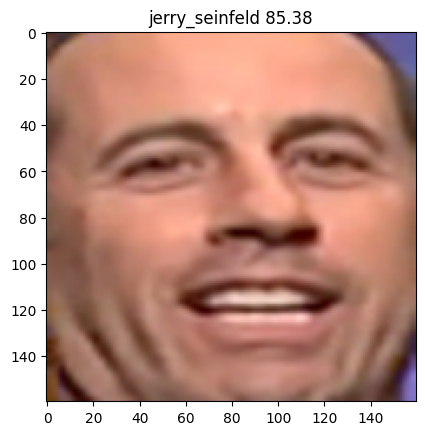

In [31]:
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

class_index = yhat_class[0]
class_probability = yhat_prob[0, class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)

all_names = out_encoder.inverse_transform(np.unique(trainy_enc))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0] * 100))
print('Expected: %s' % random_face_name[0])

plt.imshow(random_face)
title = f'{predict_names[0]} {class_probability:.2f}'
plt.title(title)
plt.show()

# Workshop 5: พล็อตดูกลุ่มข้อมูลใบหน้า

In [32]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

X shape (93, 512)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 93 samples in 0.001s...
[t-SNE] Computed neighbors for 93 samples in 0.133s...
[t-SNE] Computed conditional probabilities for sample 93 / 93
[t-SNE] Mean sigma: 0.609858
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.724808
[t-SNE] KL divergence after 1000 iterations: 0.069792


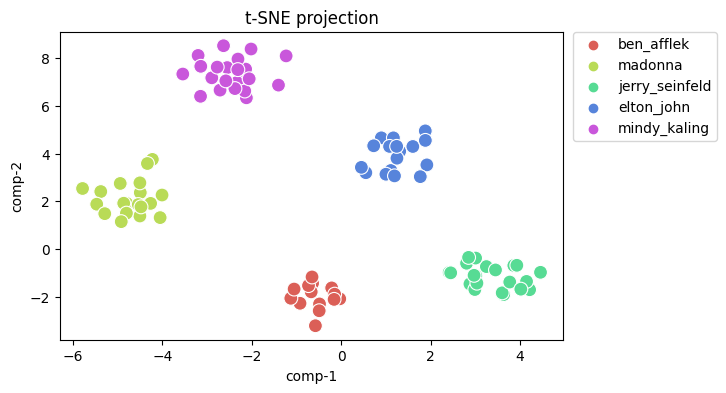

In [34]:
n_classes = len(np.unique(trainy_enc))
y_train = trainy_enc
x_mnist = emdTrainX_norm
print('X shape', x_mnist.shape)

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x_mnist)

df = pd.DataFrame()
df["y"] = y_train
df["y_cls"] = trainy
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

plt.figure(figsize=(6.5, 4))
sns.scatterplot(x="comp-1", y="comp-2", s=100, hue=df.y_cls.tolist(), palette=sns.color_palette("hls", n_classes), data=df).set(title="t-SNE projection")
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)